In [1]:
!pip install colorama

In [2]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [4]:
bitcoindf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinML/BNB-USD.csv')

In [5]:
bitcoindf = bitcoindf.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
bitcoindf.head()

,date,open,high,low,close,adj_close,volume
0,2017-09-13,1.042900,1.042900,0.880241,0.937204,0.937204,2780700.0
1,2017-09-14,0.937870,0.950177,0.673482,0.678784,0.678784,3134360.0
2,2017-09-15,0.683305,0.849217,0.526755,0.799709,0.799709,4625680.0
3,2017-09-16,0.808056,0.927197,0.746113,0.804198,0.804198,2829570.0
4,2017-09-17,0.803423,0.814797,0.733745,0.789589,0.789589,1273640.0


In [6]:
bitcoindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1462 non-null   object 
 1   open       1458 non-null   float64
 2   high       1458 non-null   float64
 3   low        1458 non-null   float64
 4   close      1458 non-null   float64
 5   adj_close  1458 non-null   float64
 6   volume     1458 non-null   float64
dtypes: float64(6), object(1)
memory usage: 80.1+ KB


In [7]:
bitcoindf.isna().sum()

,0
date,0
open,4
high,4
low,4
close,4
adj_close,4
volume,4


In [8]:
bitcoindf = bitcoindf.fillna(method = 'ffill')

<ipython-input-8-0319ec1241e9>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  bitcoindf = bitcoindf.fillna(method = 'ffill')


In [9]:
bitcoindf.isna().sum()

,0
date,0
open,0
high,0
low,0
close,0
adj_close,0
volume,0


In [10]:
bitcoindf.head()

,date,open,high,low,close,adj_close,volume
0,2017-09-13,1.042900,1.042900,0.880241,0.937204,0.937204,2780700.0
1,2017-09-14,0.937870,0.950177,0.673482,0.678784,0.678784,3134360.0
2,2017-09-15,0.683305,0.849217,0.526755,0.799709,0.799709,4625680.0
3,2017-09-16,0.808056,0.927197,0.746113,0.804198,0.804198,2829570.0
4,2017-09-17,0.803423,0.814797,0.733745,0.789589,0.789589,1273640.0


In [11]:
bitcoindf['date'] = pd.to_datetime(bitcoindf.date)
bitcoindf.head().style.set_properties(subset=['date','close'], **{'background-color': 'skyblue'})

,date,open,high,low,close,adj_close,volume
0,2017-09-13 00:00:00,1.042900,1.042900,0.880241,0.937204,0.937204,2780700.000000
1,2017-09-14 00:00:00,0.937870,0.950177,0.673482,0.678784,0.678784,3134360.000000
2,2017-09-15 00:00:00,0.683305,0.849217,0.526755,0.799709,0.799709,4625680.000000
3,2017-09-16 00:00:00,0.808056,0.927197,0.746113,0.804198,0.804198,2829570.000000
4,2017-09-17 00:00:00,0.803423,0.814797,0.733745,0.789589,0.789589,1273640.000000


Text(0.5, 1.0, 'Bitcoin Close Price')

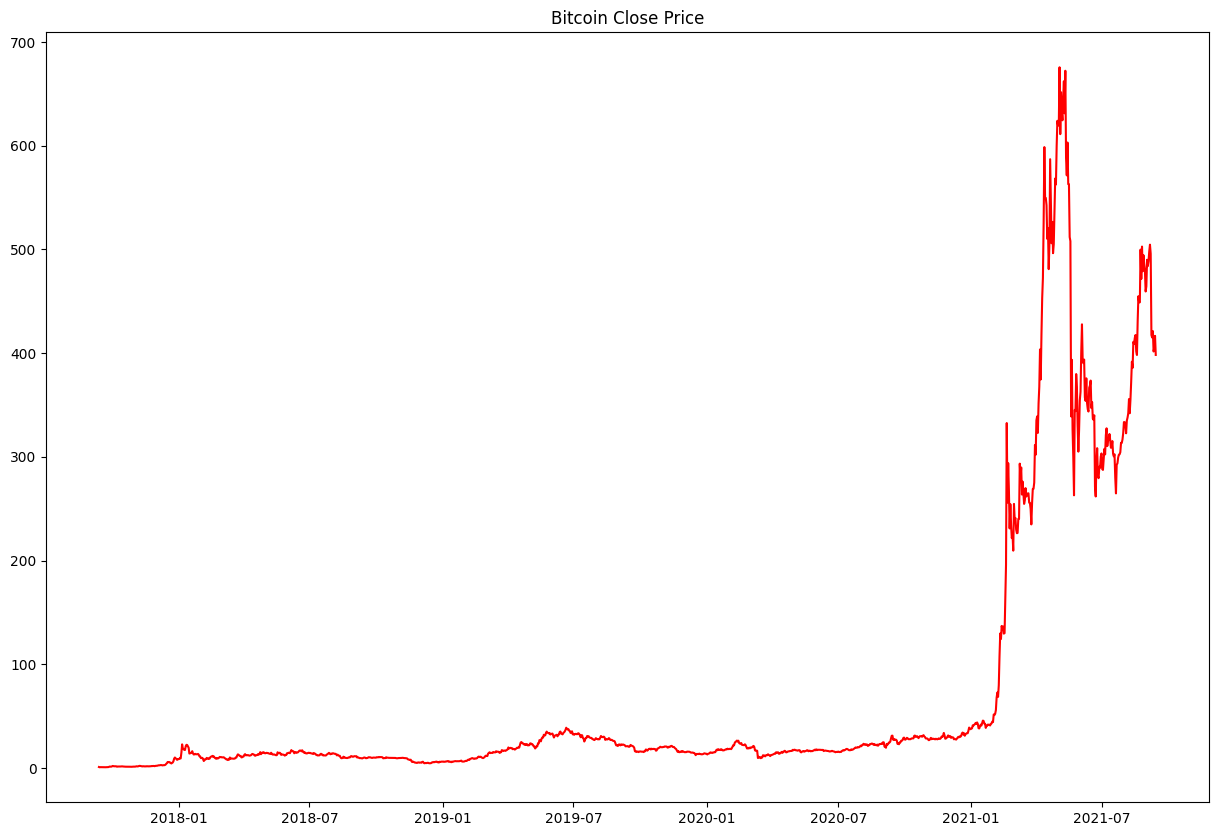

In [12]:
fig = plt.figure(figsize = (15,10))
plt.plot(bitcoindf['date'], bitcoindf['close'], color="red")
plt.title('Bitcoin Close Price')

In [13]:
last1year_bitcoindf = bitcoindf[bitcoindf['date'] > '09-2020']

Text(0.5, 1.0, 'Bitcoin Close Price')

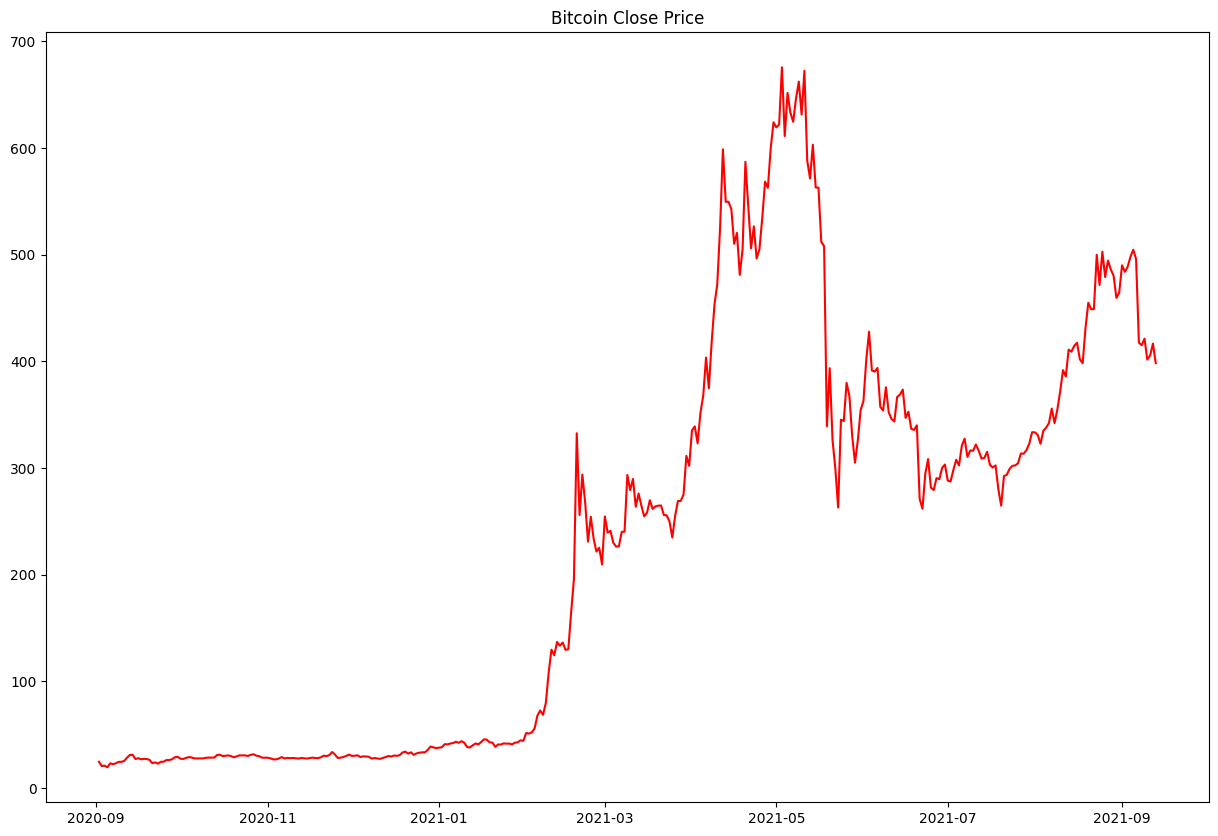

In [14]:
fig = plt.figure(figsize = (15,10))
plt.plot(last1year_bitcoindf['date'], last1year_bitcoindf['close'], color="red")
plt.title('Bitcoin Close Price')

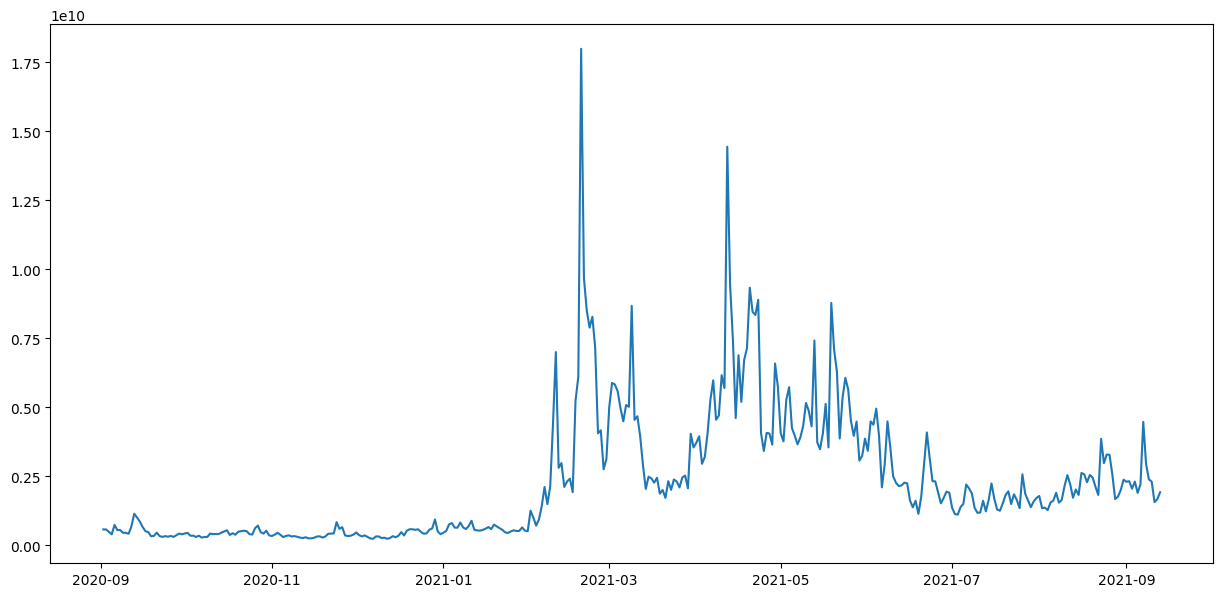

In [15]:
fig = plt.figure(figsize = (15,7))
plt.plot(last1year_bitcoindf['date'] , last1year_bitcoindf['volume'])

In [16]:
closedf = bitcoindf[['date','close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (1462, 2)


In [17]:
closedf = closedf[closedf['date'] > '2020-09-13']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  365


In [18]:
del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(365, 1)


In [19]:
#Spliting the data for train and test
training_size=int(len(closedf)*0.70)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (255, 1)
test_data:  (110, 1)


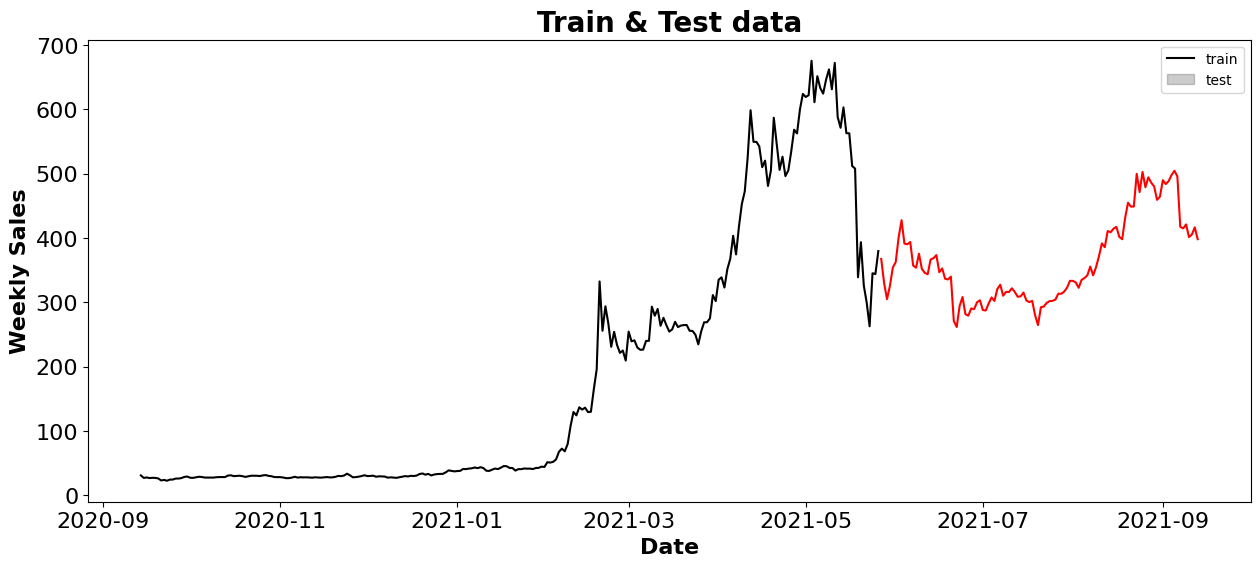

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = close_stock['date'][:255], y = close_stock['close'][:255], color = 'black')
sns.lineplot(x = close_stock['date'][255:], y = close_stock['close'][255:], color = 'red')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))

In [21]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [22]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (239, 15)
y_train:  (239,)
X_test:  (94, 15)
y_test (94,)


In [23]:
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

In [24]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
my_model = XGBRegressor()
grid_search = GridSearchCV(estimator=my_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)

In [25]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [26]:
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

my_model = grid_search.best_estimator_


Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.9}


In [27]:
predictions = my_model.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.05588924764822381
Root Mean squared Error - RMSE : 0.06624510322563888


In [28]:
train_predict=my_model.predict(X_train)
test_predict=my_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (239, 1)
Test data prediction: (94, 1)


In [29]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [30]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Close price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (365, 1)
Test predicted data:  (365, 1)


/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()
